In [1]:
# Edit this
frame_num = 40

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path

%matplotlib inline

In [3]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')

%load_ext autoreload
%autoreload 2

In [4]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose, get_joint_pose

In [5]:
weight_name = openpose_dir.joinpath('network/weight/pose_model.pth')

model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()
pass

Bulding VGG19


In [6]:
save_dir = Path('../data/target/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

../data/target/images/img_0.png


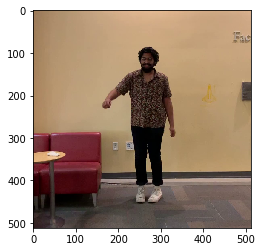

In [7]:
img_path = sorted(img_dir.iterdir())[1]
img = cv2.imread(str(img_path))
print(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

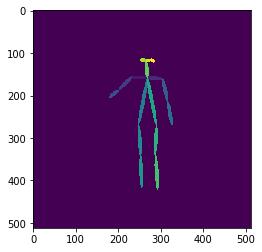

In [8]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label = get_pose(param, heatmap, paf)

plt.imshow(label)

In [9]:
# access ankles through src/util/openpose_utils.py getpose()
# created get_joint_pose()
# 10 = right ankle
# 13 = left ankle

pos_rankle = get_joint_pose(param, heatmap, paf, 10)
print(pos_rankle) # x, y, ., joint


[[255.        417.          0.4871183  10.       ]]


In [10]:
pos_lankle = get_joint_pose(param, heatmap, paf, 13)
print(pos_lankle) # x, y, ., joint


[[292.         421.           0.64621294  13.        ]]


In [11]:
train_dir = save_dir.joinpath('train')
train_dir.mkdir(exist_ok=True)

train_img_dir = train_dir.joinpath('train_img')
train_img_dir.mkdir(exist_ok=True)
train_label_dir = train_dir.joinpath('train_label')
train_label_dir.mkdir(exist_ok=True)

for idx in tqdm(range(480, 480 + frame_num)):
#for idx in tqdm(range(120, 124)):
    img_path = img_dir.joinpath('img_{:d}.png'.format(idx))
    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad():
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label = get_pose(param, heatmap, paf)
    
    #cv2.imwrite(str(train_img_dir.joinpath(f'img_{idx:04d}.png')), img)   
    cv2.imwrite(str(train_img_dir.joinpath('img_{:04d}.png'.format(idx))), img)    
    #cv2.imwrite(str(train_label_dir.joinpath(f'label_{idx:04d}.png')), label)
    cv2.imwrite(str(train_label_dir.joinpath('label_{:04d}.png'.format(idx))), label)
    
torch.cuda.empty_cache()

100%|██████████| 40/40 [01:38<00:00,  2.65s/it]
